## Emotion Recognition Model

This notebook presents a logistic regression pipeline for recognising emotions from text. The aim is to improve classification performance across all emotion categories, with particular attention to those that are typically more difficult to predict, such as *Surprise*.

### 1. Setup

This section includes the core libraries used throughout the notebook. These cover data handling (`pandas`), text preprocessing and model training (`scikit-learn`), and result visualisation (`matplotlib` and `seaborn`). All are well-suited for this kind of classification task.

In [15]:
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

### 2. Load and Clean Data

The dataset (`Emotion-Dataset.csv`) is loaded and prepared for analysis. Cleaning steps involve:
- Removing unnamed or unnecessary columns  
- Dropping any rows with missing values in the `Text` or `Emotion` columns  
- Standardising the emotion labels to ensure consistency across the dataset

In [16]:
df = pd.read_csv('Emotion-Dataset.csv')
print(f"Loaded dataset with shape: {df.shape}")

# Identify and remove any unnamed columns
unnamed_cols = [col for col in df.columns if 'Unnamed:' in col]
if unnamed_cols:
    df.drop(columns=unnamed_cols, inplace=True)

# Drop rows with missing values in either the 'Text' or 'Emotion' columns
df.dropna(subset=['Text', 'Emotion'], inplace=True)

# Standardise the emotion labels: remove extra spaces and capitalise
df['Emotion'] = df['Emotion'].str.strip().str.capitalize()

print(f"Cleaned dataset shape: {df.shape}")
print(f"Unique emotion labels ({df['Emotion'].nunique()} classes): {sorted(df['Emotion'].unique())}")

Loaded dataset with shape: (150002, 7)
Cleaned dataset shape: (150000, 2)
Unique emotion labels (5 classes): ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']


### 3. Emotion Distribution

Before training the model, it’s helpful to understand the distribution of emotion labels. This section provides both count and percentage summaries, giving a clearer idea of how balanced (or imbalanced) the dataset is.

In [17]:
emotion_counts = df['Emotion'].value_counts()

# The percentage distribution of each class
emotion_percent = df['Emotion'].value_counts(normalize=True) * 100

# Summary table with both counts and percentages
summary_df = pd.DataFrame({
    'Count': emotion_counts,
    'Percentage': emotion_percent.round(2)
})
display(summary_df)

,Count,Percentage
Emotion,,
Sadness,41000,27.33
Joy,41000,27.33
Anger,32000,21.33
Fear,27000,18.00
Surprise,9000,6.00


### 4. Visualise Emotion Distribution

To support the summary statistics, I’ve included a bar plot that visualises how many samples fall under each emotion category. This helps identify potential class imbalances that may affect training and evaluation.

In [18]:
def show_examples(df, n_per_class=2):
    emotions = sorted(df['Emotion'].unique())
    
    for emotion in emotions:
        print(f"Examples for {emotion}:\n")
        # Get rows for this emotion
        emotion_df = df[df['Emotion'] == emotion]
        # Choose n random samples
        samples = emotion_df.sample(n=n_per_class, random_state=42)
        
        for i, (_, row) in enumerate(samples.iterrows()):
            print(f"Example {i+1}:")
            print(f"Text: {row['Text']}")
            print("-" * 50)

show_examples(df)

Examples for Anger:

Example 1:
Text: i hear friends talk about racing and see posts about upcoming races i feel the bitter sweetness of this end and beginning coming over me
--------------------------------------------------
Example 2:
Text: i feel i m going too mad and random with fabric choices then i look to rein it back in by using black and white fabrics or a neutral or even a patterned fabric that i then start to use a bit more than all the others
--------------------------------------------------
Examples for Fear:

Example 1:
Text: i encounter such violations i feel unprotected and the idea that its dangerous out there sets in hard
--------------------------------------------------
Example 2:
Text: i am simply to realize that master homis knows best and if he feels there is too much going on he will step in and help with some tasks that i perform and i am not to become distressed about this
--------------------------------------------------
Examples for Joy:

Example 1:
Text: 

### 5. Text Preprocessing

A custom preprocessing function is defined to clean the text data. The function includes:
- Converting text to lowercase  
- Removing punctuation and non-alphabetic characters  
- Expanding common contractions  
- Tokenising the text and optionally applying lemmatisation  

These steps help prepare the text for vectorisation and modelling.

In [19]:
def enhanced_preprocess_text(text):
    if not isinstance(text, str):
        return ""  # Return empty string for non-string inputs
    
    # Lowercase conversion
    text = text.lower()
    
    # Handle contractions and negations with word boundaries
    text = re.sub(r"\bn't\b", " not", text)
    
    # Emotion-specific patterns with word boundaries
    negation_replacements = [
        (r"\bnot happy\b|\bunhappy\b", " sad"),
        (r"\bnot sad\b", " happy")
    ]
    
    intensity_replacements = [
        (r"\b(very|really|extremely|totally|so)\b", "intensifier")
    ]
    
    emotion_indicators = [
        (r"\b(lol|haha|hehe)\b", "joy_indicator"),
        (r"\b(omg|wow|whoa|what)\b", "surprise_indicator"),
        (r"\b(hate|angry|mad)\b", "anger_indicator"),
        (r"\b(worried|scared|afraid|nervous)\b", "fear_indicator"),
        (r"\b(sad|depressed|sorrow|grief)\b", "sadness_indicator")
    ]
    
    # Apply all replacements
    for pattern, replacement in negation_replacements + intensity_replacements + emotion_indicators:
        text = re.sub(pattern, replacement, text)
    
    # Handle punctuation
    text = re.sub(r'[^a-zA-Z\s!?]', '', text)
    text = re.sub(r'!{2,}', ' strong_emotion ', text)
    text = re.sub(r'\?{2,}', ' strong_confusion ', text)
    
    # Clean up whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

### 6. Stratified 80/10/10 Data Split

To ensure consistent representation across all classes, I’ve used `StratifiedShuffleSplit` to divide the data into training (80%), validation (10%), and test (10%) sets. This approach maintains the overall distribution of emotion labels in each subset.

In [20]:
print("Splitting data into train, validation, and test sets (80/10/10)")

# First we split off 10% for the test set 
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_val_idx, test_idx = next(stratified_split.split(df['Text'], df['Emotion']))

# Now we split remaining 90% into 80% for training and 10% for validation
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=1/8, random_state=42)
train_idx, val_idx = next(stratified_split.split(df.iloc[train_val_idx]['Text'], df.iloc[train_val_idx]['Emotion']))

# This essentially gives us 80% train, 10% validation, and 10% test sets
df_train = df.iloc[train_val_idx].iloc[train_idx].reset_index(drop=True)
df_val = df.iloc[train_val_idx].iloc[val_idx].reset_index(drop=True)
df_test = df.iloc[test_idx].reset_index(drop=True)

print(f"Train set size: {len(df_train)} samples")
print(f"Validation set size: {len(df_val)} samples")
print(f"Test set size: {len(df_test)} samples")

Splitting data into train, validation, and test sets (80/10/10)
Train set size: 118125 samples
Validation set size: 16875 samples
Test set size: 15000 samples


### 7. Preprocess Text and Extract Labels

The cleaning function is now applied to each data split. Labels are also extracted separately, so that the cleaned text and corresponding emotion categories are ready for feature extraction and training.

In [21]:
print("Applying text preprocessing")

# Apply the enhanced text preprocessing function to each split
texts_train = df_train['Text'].apply(enhanced_preprocess_text).values
texts_val = df_val['Text'].apply(enhanced_preprocess_text).values
texts_test = df_test['Text'].apply(enhanced_preprocess_text).values

# Extract emotion labels for training, validation, and test sets
emotions_train = df_train['Emotion']
emotions_val = df_val['Emotion']
emotions_test = df_test['Emotion']

print("Preprocessing complete.")

Applying text preprocessing
Preprocessing complete.


### 8. TF-IDF Feature Extraction

Text data is vectorised using TF-IDF, which transforms the cleaned text into numerical form. This method reduces the influence of very common words while highlighting more distinctive ones, making it easier for the model to distinguish between emotion classes.

In [22]:
print("TF-IDF feature extraction")

tfidf = TfidfVectorizer(
    max_features=15000,        # Keep the top 15k features
    ngram_range=(1, 2),        # Use unigrams and bigrams (single words and pairs)
    min_df=3,                  # Ignore words that appear in fewer than 3 documents
    max_df=0.95,               # Ignore words that appear in more than 95% of documents
    use_idf=True,              # Boost rare words, downplay common ones
    sublinear_tf=True,         # Scale word counts with log function
    strip_accents='unicode',   # Remove accents from characters
    analyzer='word'            # Split text into words
)

# Fit on training data and transform val and test subsets
texts_train_tfidf = tfidf.fit_transform(texts_train)
texts_val_tfidf = tfidf.transform(texts_val)
texts_test_tfidf = tfidf.transform(texts_test)

print(f"TF-IDF feature extraction complete. Total features: {texts_train_tfidf.shape[1]}")

TF-IDF feature extraction
TF-IDF feature extraction complete. Total features: 15000


### 9. Train Logistic Regression

A logistic regression model is trained using the TF-IDF vectors. To improve learning and generalisation, the following adjustments are made:
- Class weights are set to ‘balanced’ to reduce the impact of class imbalance  
- The maximum number of iterations is increased to ensure the model converges properly

In [23]:
print("Training Improved Logistic Regression model")

improved_model = LogisticRegression(
    C=2.0,                     # Regularisation strength
    penalty='l2',              # It essentially prevents overfitting
    solver='liblinear',        # Good for medium to large sized datasets
    max_iter=8000,             # More steps to converge
    class_weight='balanced',   # Fixes class imbalance
    random_state=42,           # For reproducibility
)

improved_model.fit(texts_train_tfidf, emotions_train)

print(f"Training complete. Model learned {improved_model.coef_.shape[1]} feature weights.")

Training Improved Logistic Regression model
Training complete. Model learned 15000 feature weights.


### 10. Validation and Test Performance

The trained model is evaluated on both the validation and test sets. Results include overall accuracy and a comparison of predicted vs actual emotion labels. This helps to identify any potential issues in how the model generalises across datasets.

In [24]:
print("Improved Model Evaluation:")

# Validation set evaluation
val_preds = improved_model.predict(texts_val_tfidf)
val_accuracy = accuracy_score(emotions_val, val_preds)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Test set evaluation
test_preds = improved_model.predict(texts_test_tfidf)
test_accuracy = accuracy_score(emotions_test, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Another DataFrame for comparing true vs predicted distributions
class_distribution = pd.DataFrame({
    'True Count': emotions_test.value_counts(),
    'Predicted Count': pd.Series(test_preds).value_counts()
})

class_distribution['True %'] = (class_distribution['True Count'] / len(emotions_test) * 100).round(2)
class_distribution['Predicted %'] = (class_distribution['Predicted Count'] / len(test_preds) * 100).round(2)
class_distribution['Difference %'] = (class_distribution['Predicted %'] - class_distribution['True %']).round(2)

print("\nEmotion Distribution Comparison (Test Set):")
display(class_distribution)

Improved Model Evaluation:
Validation Accuracy: 0.9102
Test Accuracy: 0.9118

Emotion Distribution Comparison (Test Set):


,True Count,Predicted Count,True %,Predicted %,Difference %
Joy,4100,4005,27.33,26.70,-0.63
Sadness,4100,3956,27.33,26.37,-0.96
Anger,3200,3249,21.33,21.66,0.33
Fear,2700,2682,18.00,17.88,-0.12
Surprise,900,1108,6.00,7.39,1.39


### 11. Confusion Matrix Visualisation

To better understand where the model performs well or struggles, a confusion matrix is plotted. This visualises correct predictions along the diagonal and misclassifications elsewhere. A full classification report is also included, showing precision, recall, and F1-scores for each class.

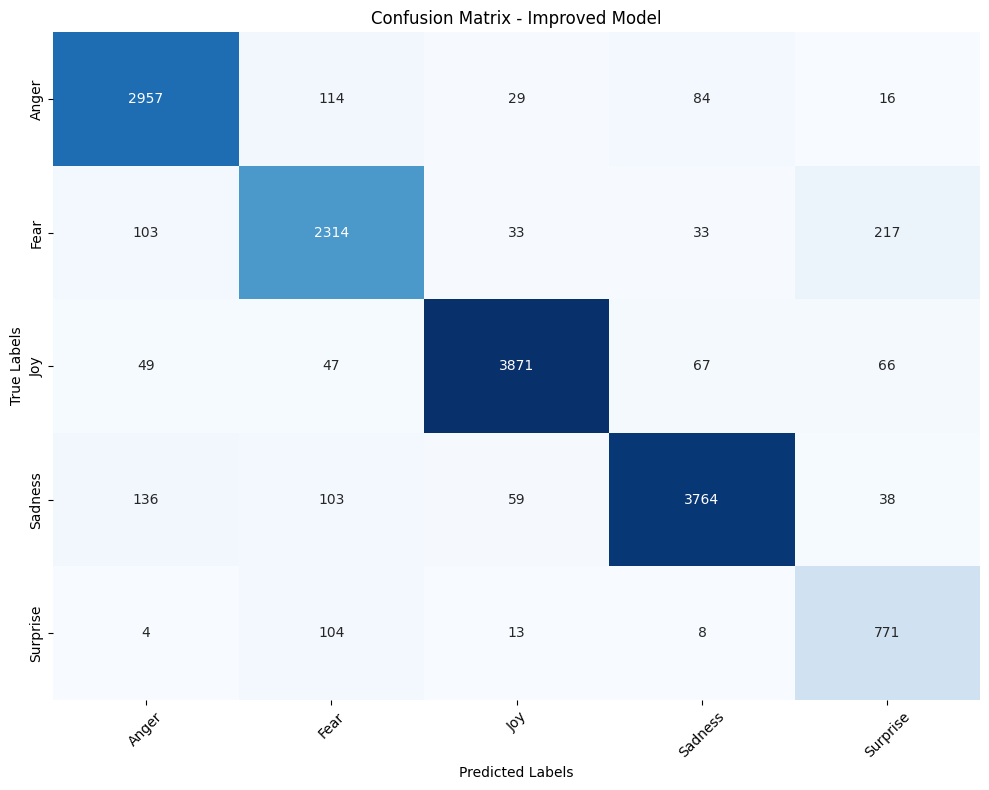

Detailed Classification Report:
              precision    recall  f1-score   support

       Anger       0.91      0.92      0.92      3200
        Fear       0.86      0.86      0.86      2700
         Joy       0.97      0.94      0.96      4100
     Sadness       0.95      0.92      0.93      4100
    Surprise       0.70      0.86      0.77       900

    accuracy                           0.91     15000
   macro avg       0.88      0.90      0.89     15000
weighted avg       0.92      0.91      0.91     15000



In [25]:
cm = confusion_matrix(emotions_test, test_preds)
plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=sorted(df['Emotion'].unique()),
    yticklabels=sorted(df['Emotion'].unique()),
    cbar=False
)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Improved Model')
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Detailed Classification Report:")
class_report = classification_report(emotions_test, test_preds)
print(class_report)

### 12. Feature Importance Analysis

This section looks into which features (i.e. words) the model considers most important when making predictions. By examining the learned weights, we can identify the top 10 contributing words for each emotion class. This offers useful insight into the model’s decision-making process.

Top Predictive Words for Each Emotion Class:


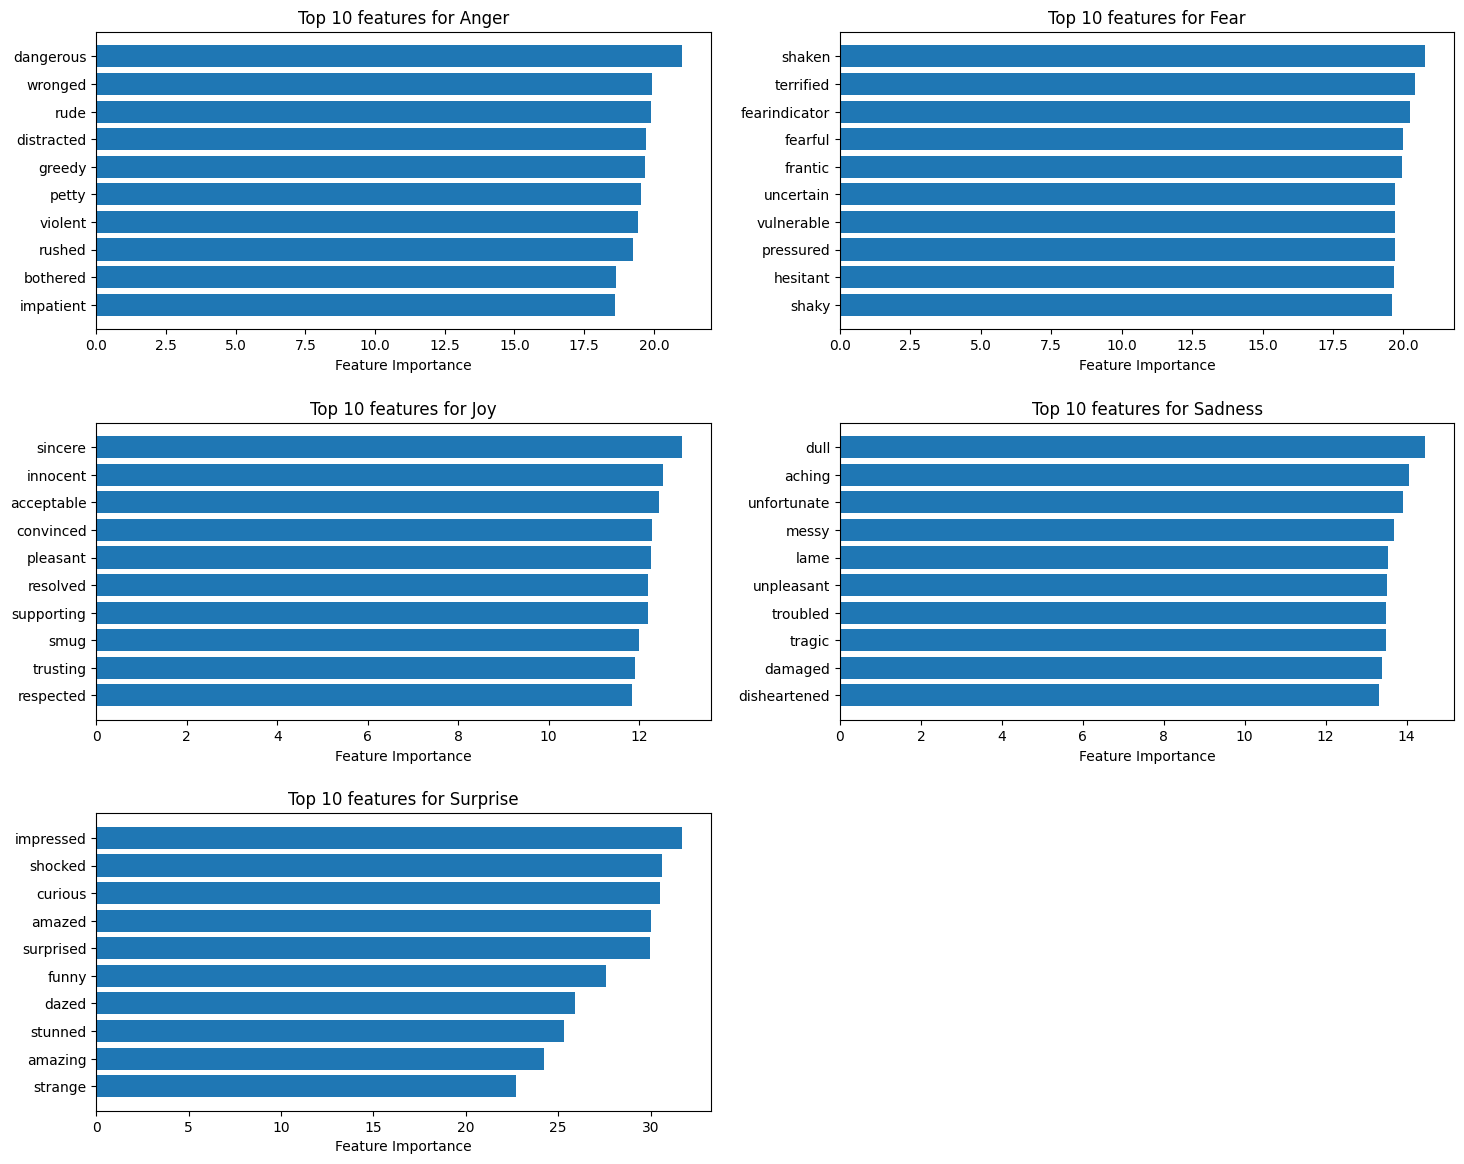

In [26]:
def display_top_features(model, feature_names, class_names, n=10):
    plt.figure(figsize=(15, 12))
    
    for i, cls in enumerate(class_names):
        plt.subplot(3, 2, i+1)
        
        # Get coefficients for this class
        class_idx = list(model.classes_).index(cls)
        coefs = model.coef_[class_idx]
        
        # Sort coefficients
        top_indices = np.argsort(coefs)[-n:]
        top_features = [feature_names[idx] for idx in top_indices]
        top_coefs = [coefs[idx] for idx in top_indices]
        
        y_pos = np.arange(len(top_features))
        plt.barh(y_pos, top_coefs, align='center')
        plt.yticks(y_pos, top_features)
        plt.title(f'Top {n} features for {cls}')
        plt.xlabel('Feature Importance')
    
    plt.tight_layout(pad=2.0)
    plt.show()

# Get feature names from the TF-IDF vectorizer
feature_names = np.array(tfidf.get_feature_names_out())
class_names = sorted(improved_model.classes_)

print("Top Predictive Words for Each Emotion Class:")
display_top_features(improved_model, feature_names, class_names, n=10)

### 13. Error Analysis

To explore the model’s limitations, I’ve carried out a simple error analysis. This includes:
- A breakdown of which emotions are most frequently confused  
- Examples of misclassified text inputs  
- A calculation of the overall error rate  

This analysis helps pinpoint where improvements could be made, either through better data or model adjustments.

In [27]:
# Find misclassified examples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(emotions_test, test_preds)) 
                         if true != pred]

if misclassified_indices:
    # Count error types
    error_types = {}
    for i in misclassified_indices:
        true = emotions_test.iloc[i]
        pred = test_preds[i]
        error_pair = (true, pred)
        error_types[error_pair] = error_types.get(error_pair, 0) + 1
    
    print("Most common misclassification types:")
    for (true, pred), count in sorted(error_types.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {true} - {pred}: {count} examples")
    
    # Show examples of the most common error type
    most_common_error = max(error_types.items(), key=lambda x: x[1])[0]
    true_label, pred_label = most_common_error
    
    examples = [i for i in misclassified_indices 
              if emotions_test.iloc[i] == true_label and test_preds[i] == pred_label][:2]
    
    print(f"\nExample misclassifications of {true_label} as {pred_label}:")
    for i, idx in enumerate(examples):
        print(f"Example {i+1}: \"{texts_test[idx]}\"")
        
    # The overall error rate
    error_rate = len(misclassified_indices) / len(emotions_test)
    print(f"\nOverall error rate: {error_rate:.4f} ({len(misclassified_indices)} out of {len(emotions_test)} examples)")

Most common misclassification types:
  Fear - Surprise: 217 examples
  Sadness - Anger: 136 examples
  Anger - Fear: 114 examples
  Surprise - Fear: 104 examples
  Sadness - Fear: 103 examples

Example misclassifications of Fear as Surprise:
Example 1: "i feel weird typing this because i m pretty introverted and can be incredibly anti social"
Example 2: "i encrypt the feeling i now feel on these pages in this strange language still avoids capture that depth no rabbit hole dream clich could capture the unraveling path as it unfolds every single time"

Overall error rate: 0.0882 (1323 out of 15000 examples)


### 14. Predict Single Examples

Lastly, I’ve added a function for predicting the emotion behind a single piece of text. It’s demonstrated using examples from both the test set and some new inputs. This serves as a practical check on how the model responds to unseen data.

In [28]:
def predict_emotion(text):
    cleaned_text = enhanced_preprocess_text(text)
    tfidf_features = tfidf.transform([cleaned_text])
    predicted_emotion = improved_model.predict(tfidf_features)[0]
    return predicted_emotion

# Extract examples for each emotion class from the test set
def get_examples_by_class(df, n_examples=2):
    examples_dict = {}
    
    for emotion in sorted(df['Emotion'].unique()):
        # Filter examples where predicted emotion matches actual emotion
        emotion_texts = df[df['Emotion'] == emotion]['Text'].values
        if len(emotion_texts) >= n_examples:
            examples_dict[emotion] = emotion_texts[:n_examples]
        else:
            examples_dict[emotion] = emotion_texts
    
    return examples_dict

print("Extracting examples from the test set for each emotion class:\n")
examples_by_class = get_examples_by_class(df_test, n_examples=2)

print("Example predictions:\n")
for emotion, example_texts in examples_by_class.items():
    print(f"Emotion: {emotion}")
    for i, example in enumerate(example_texts):
        predicted = predict_emotion(example)
        is_correct = "(yes)" if predicted == emotion else "(no)"
        print(f"  Example {i+1}: {example[:100]}.")
        print(f"  Predicted: {predicted} {is_correct}")
    print("-" * 50)

print("\nAdditional examples for each emotion class:")
print("=" * 50)

custom_examples = {
    "Joy": "Today has been the happiest day of my life, everything feels perfect!",
    "Sadness": "I can't stop crying after hearing the news about my friend's illness.",
    "Anger": "I'm absolutely furious about how they treated our team at the meeting.",
    "Fear": "I'm terrified of what might happen if I fail this important exam.",
    "Surprise": "Wow! I never expected to win the lottery, I'm completely shocked!"
}

for emotion, example in custom_examples.items():
    predicted = predict_emotion(example)
    print(f"Emotion category: {emotion}")
    print(f"Example text: {example}")
    print(f"Predicted emotion: {predicted}")
    print("-" * 50)

Extracting examples from the test set for each emotion class:

Example predictions:

Emotion: Anger
  Example 1: i feel like my patients are disgusted and appalled that i would come to work sick and work with them.
  Predicted: Anger (yes)
  Example 2: i am feeling rather envious this week as debby has flown off to sardinia i certainly hope she is hav.
  Predicted: Anger (yes)
--------------------------------------------------
Emotion: Fear
  Example 1: i feel weird typing this because i m pretty introverted and can be incredibly anti social.
  Predicted: Surprise (no)
  Example 2: i was talking to told me i feel so vulnerable and i thought to myself what does that really mean.
  Predicted: Fear (yes)
--------------------------------------------------
Emotion: Joy
  Example 1: i feel relieved to know that angela bassett is at the artistic helm of the inevitable whitney housto.
  Predicted: Joy (yes)
  Example 2: ive finally settled back into my routine for the most part and am feeling 